In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
domains = pd.read_csv('TRANCO_1M_MASTER.csv')
domains = domains.head(100)

In [7]:
domains.columns = ['index', 'domain']
domains.drop('index', inplace=True, axis=1)

In [8]:
domains.head()

,domain
0,google.com
1,youtube.com
2,facebook.com
3,microsoft.com
4,twitter.com


In [9]:
# Find the TLD for each domain
domains['TLD'] = domains['domain'].apply(lambda x : x.split('.')[-1])

tld_counts = domains.groupby('TLD').count()
tld_counts.reset_index(inplace=True)
tld_counts.head()

,TLD,domain
0,be,1
1,cn,2
2,co,1
3,com,72
4,eu,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

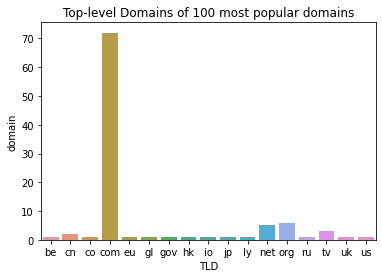

In [17]:
# Histogram of top 100 domains and their TLDs
from google.colab import files
plot = sns.barplot(x='TLD', y='domain', data=tld_counts)
plt.title("Top-level Domains of 100 most popular domains")
#plt.show()
plt.savefig('hist.png', dpi=100)
files.download('hist.png')

## Visualizations for MEGA csv

In [72]:
from google.colab import files
mega = pd.read_csv('MASTER_RESULTS.csv')
mega.head()

,site,rank,tld,tld_type,country,delv_result
0,google.com,1,com,gTLD,US,0
1,youtube.com,2,com,gTLD,US,0
2,facebook.com,3,com,gTLD,US,0
3,microsoft.com,4,com,gTLD,US,0
4,twitter.com,5,com,gTLD,US,0


In [73]:
from matplotlib.pyplot import pie
dnssec_support = mega.groupby('delv_result').count().site
dnssec_support

delv_result
-2      3227
-1      7366
 0    939165
 1     50242
Name: site, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

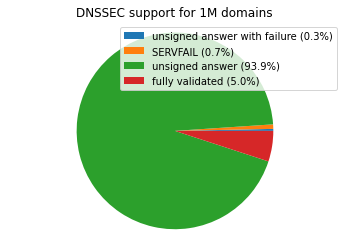

In [146]:
# Pie chart for DNSSEC support for domains
labels=['unsigned answer with failure (0.3%)','SERVFAIL (0.7%)','unsigned answer (93.9%)', 'fully validated (5.0%)']
pie(dnssec_support,pctdistance=2)
plt.title("DNSSEC support for 1M domains")
plt.axis('equal')
plt.legend(labels=labels,loc="best")
plt.savefig('dnssec_domains.png',dpi=100)

#plt.tight_layout()
files.download('dnssec_domains.png')

In [95]:
mega.head()

,site,rank,tld,tld_type,country,delv_result
0,google.com,1,com,gTLD,US,0
1,youtube.com,2,com,gTLD,US,0
2,facebook.com,3,com,gTLD,US,0
3,microsoft.com,4,com,gTLD,US,0
4,twitter.com,5,com,gTLD,US,0


In [96]:
def isValid(r):
  if r == 1:
    return 1
  return 0

mega['is_valid'] = mega['delv_result'].map(isValid)

In [97]:
mega.head()

,site,rank,tld,tld_type,country,delv_result,is_valid
0,google.com,1,com,gTLD,US,0,0
1,youtube.com,2,com,gTLD,US,0,0
2,facebook.com,3,com,gTLD,US,0,0
3,microsoft.com,4,com,gTLD,US,0,0
4,twitter.com,5,com,gTLD,US,0,0


In [102]:
# Get the 30 most popular TLDs
thirty_pop_TLDs = mega.groupby('tld').count().sort_values(by='site', ascending=False).head(25).index.to_list()
thirty_pop_TLDs

['com',
 'org',
 'net',
 'ru',
 'de',
 'uk',
 'cn',
 'jp',
 'in',
 'nl',
 'br',
 'fr',
 'it',
 'info',
 'au',
 'co',
 'pl',
 'ca',
 'io',
 'us',
 'vn',
 'ir',
 'es',
 'eu',
 'ua']

In [103]:
total_tlds = mega.groupby('tld').is_valid.sum()

In [104]:
dnssec_tlds = mega.groupby('tld').site.count()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

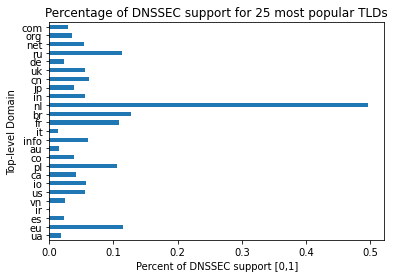

In [147]:
# Top 30 TLDs and % of DNSSEC supported
import matplotlib.ticker as mtick

ax = (total_tlds / dnssec_tlds).loc[thirty_pop_TLDs[::-1]]
ax.plot(kind="barh")
plt.title("Percentage of DNSSEC support for 25 most popular TLDs")
plt.ylabel("Top-level Domain")
plt.xlabel("Percent of DNSSEC support [0,1]")
plt.savefig('30_domains.png',dpi=100)
files.download('30_domains.png')

In [106]:
# Country heatmap based on DNSSEC and whois queries
country_results = pd.read_csv('MASTER_RESULTS.csv')

def isValid(r):
  if r == 1:
    return 1
  return 0

country_results['is_valid'] = country_results['delv_result'].map(isValid)

country_results.dropna(inplace=True)

In [107]:
country_dnssec = country_results.groupby('country').sum('is_valid').is_valid.to_frame()
country_dnssec.reset_index(inplace=True)
country_dnssec.head()

,country,is_valid
0,AD,3
1,AE,31
2,AF,9
3,AG,5
4,AI,1


In [108]:
# Convert 2-letter country codes to 3 letters
dfcountry = pd.read_csv('countryMap.txt', sep='\t')
country_dnssec = country_dnssec.merge(dfcountry, how='inner',left_on=['country'],right_on=['2let'])
country_dnssec

,country_x,is_valid,country_y,2let,3let
0,AD,3,Andorra,AD,AND
1,AE,31,United Arab Emirates,AE,ARE
2,AF,9,Afghanistan,AF,AFG
3,AG,5,Antigua and Barbuda,AG,ATG
4,AI,1,Anguilla,AI,AIA
...,...,...,...,...,...
236,YE,5,Yemen,YE,YEM
237,YT,1,Mayotte,YT,MYT
238,ZA,31,South Africa,ZA,ZAF
239,ZM,1,Zambia,ZM,ZMB


In [148]:
import plotly.express as px

fig = px.choropleth(data_frame=country_dnssec, 
                    locations='3let',
                    locationmode='ISO-3',
                    color='is_valid',
                    scope='world')

fig.write_html("country-dnssec.html")
files.download("country-dnssec.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [111]:
fig

In [112]:
# Similar Web Graph
import pandas as pd

computer_electronics = pd.read_csv('ComputerElectronicsAndTechnology_Data.csv')
computer_electronics['category'] = 'computer_electronics'
computer_security = pd.read_csv('ComputerSecurity_Data.csv')
computer_security['category'] = 'computer_security'
ecommerce = pd.read_csv('E-CommerceAndShopping_Data.csv')
ecommerce['category'] = 'ecommerce'
finance = pd.read_csv('Finance_Data.csv')
finance['category'] = 'finance'
health = pd.read_csv('Health_Data.csv')
health['category'] = 'health'
industry = pd.read_csv('HeavyIndustryAndEngineering_Data.csv')
industry['category'] = 'industry'
law_and_gov = pd.read_csv('LawAndGov_Data.csv')
law_and_gov['category'] = 'law_and_gov'
news_and_media = pd.read_csv('NewsAndMedia_Data.csv')
news_and_media['category'] = 'news_and_media'
education = pd.read_csv('ScienceAndEducation_Data.csv')
education['category'] = 'education'


In [113]:
dfs = computer_electronics.append([computer_security,ecommerce,finance,health,industry,law_and_gov,news_and_media,education])
dfs

,site,category_rank,tranco_rank,tld,tld_type,country,delv_result,category
0,google.com,1,1.0,com,gTLD,US,0,computer_electronics
1,facebook.com,2,3.0,com,gTLD,US,0,computer_electronics
2,twitter.com,3,5.0,com,gTLD,US,0,computer_electronics
3,instagram.com,4,7.0,com,gTLD,US,0,computer_electronics
4,baidu.com,5,9.0,com,gTLD,CN,0,computer_electronics
...,...,...,...,...,...,...,...,...
45,toppr.com,46,3741.0,com,gTLD,NaN,0,education
46,sinoptik.ua,47,5493.0,ua,ccTLD,UA,0,education
47,unam.mx,48,1906.0,mx,ccTLD,MX,0,education
48,analyticsapp.ru,49,237210.0,ru,ccTLD,RU,0,education


In [114]:
def isValid(r):
  if r == 1:
    return 1
  return 0

dfs['is_valid'] = dfs['delv_result'].map(isValid)

In [115]:
dfs.tail()

,site,category_rank,tranco_rank,tld,tld_type,country,delv_result,category,is_valid
45,toppr.com,46,3741.0,com,gTLD,NaN,0,education,0
46,sinoptik.ua,47,5493.0,ua,ccTLD,UA,0,education,0
47,unam.mx,48,1906.0,mx,ccTLD,MX,0,education,0
48,analyticsapp.ru,49,237210.0,ru,ccTLD,RU,0,education,0
49,brainly.com,50,3098.0,com,gTLD,PL,0,education,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

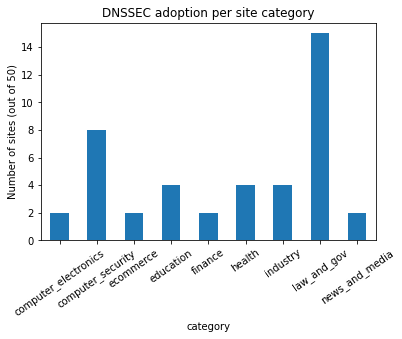

In [155]:
dfs.groupby('category').is_valid.sum().plot(kind="bar", rot=35, title="DNSSEC adoption per site category",ylabel="Number of sites (out of 50)")
plt.savefig("category.png")
files.download("category.png")

In [117]:
# Ranking buckets, 1-100, 100-1000,1000-10000,10000-100000,100000-1000000
buckets = pd.read_csv('MASTER_RESULTS.csv').sort_values(by="rank")

In [118]:
buckets.head()

,site,rank,tld,tld_type,country,delv_result
0,google.com,1,com,gTLD,US,0
1,youtube.com,2,com,gTLD,US,0
2,facebook.com,3,com,gTLD,US,0
3,microsoft.com,4,com,gTLD,US,0
4,twitter.com,5,com,gTLD,US,0


In [119]:
df_1 = buckets.iloc[:100]
print(len(df_1))
df_2 = buckets.iloc[100:1000]
print(len(df_2))
df_3 = buckets.iloc[1000:10000]
print(len(df_3))
df_4 = buckets.iloc[10000:100000]
print(len(df_4))
df_5 = buckets.iloc[100000:]
print(len(df_5))
df_buckets = [df_1, df_2, df_3, df_4, df_5]

100
900
9000
90000
900000


In [ ]:
# Pie chart for DNSSEC support for domains
labels=['unsigned answer with failure (0.3%)','SERVFAIL (0.7%)','unsigned answer (93.9%)', 'fully validated (5.0%']
pie(dnssec_support,pctdistance=2)
plt.title("DNSSEC support for 1M domains")
plt.axis('equal')
plt.savefig('dnssec_domains.png',dpi=100)
plt.legend(labels=labels,loc="best")
plt.tight_layout()
#files.download('dnssec_domains.png')

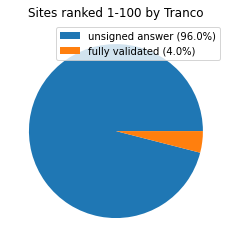

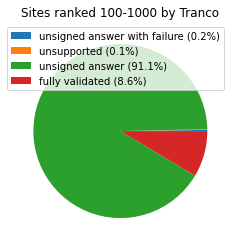

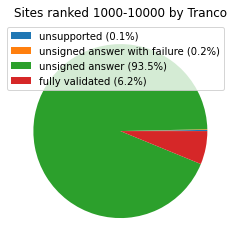

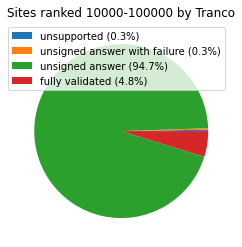

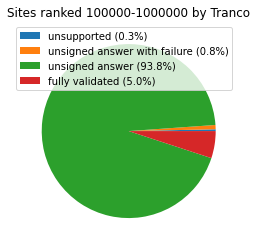

In [144]:
import matplotlib.pyplot as plt


plt.figure(0)
labels_1 = ['unsigned answer (96.0%)', 'fully validated (4.0%)']
df_1.groupby('delv_result').count().site.plot(kind="pie",title="Sites ranked 1-100 by Tranco",ylabel='',xlabel='',labels=['',''])
plt.legend(labels=labels_1)

plt.figure(1)
labels_2 = ['unsigned answer with failure (0.2%)','unsupported (0.1%)','unsigned answer (91.1%)', 'fully validated (8.6%)']
df_2.groupby('delv_result').count().site.plot(kind="pie",title="Sites ranked 100-1000 by Tranco",ylabel='',xlabel='',labels=['','','',''])
plt.legend(labels=labels_2)

plt.figure(2)
labels_3 = ['unsupported (0.1%)','unsigned answer with failure (0.2%)','unsigned answer (93.5%)', 'fully validated (6.2%)']
df_3.groupby('delv_result').count().site.plot(kind="pie",title="Sites ranked 1000-10000 by Tranco",ylabel='',labels=['','','',''])   
plt.legend(labels=labels_3)

plt.figure(3)
labels_4 = ['unsupported (0.3%)','unsigned answer with failure (0.3%)','unsigned answer (94.7%)', 'fully validated (4.8%)']
df_4.groupby('delv_result').count().site.plot(kind="pie",title="Sites ranked 10000-100000 by Tranco",ylabel='',labels=['','','',''])
plt.legend(labels=labels_4)

plt.figure(4)
labels_5 = ['unsupported (0.3%)','unsigned answer with failure (0.8%)','unsigned answer (93.8%)', 'fully validated (5.0%)']
df_5.groupby('delv_result').count().site.plot(kind="pie",title="Sites ranked 100000-1000000 by Tranco",ylabel='',labels=['','','',''])
plt.legend(labels=labels_5)

plt.show()
